# Bots trading analysis

## Round 4
- COCONUT: Raj, Vinnie
- COCONUT_COUPON: Valentina, Vinnie, Vladimir 

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
# Bots that start with the same letter are from the same snake family
bots = ["Valentina", "Vinnie", "Vladimir", "Vivian", 
       "Celeste", "Colin", "Carlos", "Camilla", 
       "Pablo", "Penelope", "Percy", "Petunia",
       "Ruby", "Remy", "Rhianna", "Raj",
       "Amelia", "Adam", "Alina", "Amir"]


bot_colours = [
    "#FF0000", "#FF3300", "#FF6600", "#FF9900",
    "#FFA500", "#FFC400", "#FFD700", "#FFEC80",
    "#FFFF00", "#FFFF80", "#FFFFBF", "#FFFFE0",
    "#008000", "#00AA00", "#00CC00", "#00FF00",
    "#0000FF", "#3366FF", "#6699FF", "#99CCFF"
]

# Read data
round_num = 4
day_num = 1

csv_file_path_trades = f"./data/round_{round_num}/trades_round_{round_num}_day_{day_num}_wn.csv"
csv_file_path_orders = f"./data/round_{round_num}/prices_round_{round_num}_day_{day_num}.csv"

df_trades = pd.read_csv(csv_file_path_trades, sep=';')
df_orders = pd.read_csv(csv_file_path_orders, sep=';')

# Data sanitization: remove rows with buyer == seller
df_trades = df_trades[df_trades['buyer'] != df_trades['seller']]


products = np.unique(df_trades['symbol'])

buy_trades  = {}
sell_trades = {}
orders = {}

for prod in products:
    # Dict: prod -> bot -> trades
    buy_trades[prod] = {}
    sell_trades[prod] = {}
    
    for b in bots:
        buy_trades[prod][b] = df_trades[(df_trades['symbol'] == prod) & ((df_trades['buyer'] == b))]
        sell_trades[prod][b] = df_trades[(df_trades['symbol'] == prod) & ((df_trades['seller'] == b))]
        
    orders[prod] = df_orders[df_orders['product'] == prod]

# Direct proportionat cu volum

In [28]:
def plot_trades(trades, prod, range, title=""):
    fig, ax = plt.subplots(figsize=(11, 6))

    for b, c in zip(bots, bot_colours):
        if len(trades[prod][b]) == 0:
            continue
            
        time_mask = ((trades[prod][b]['timestamp'] > range[0]) 
                     & (trades[prod][b]['timestamp'] < range[1]))
        
        ax.scatter(trades[prod][b]['timestamp'][time_mask],
                   trades[prod][b]['price'][:range[1]][time_mask], 
                   label=b, color=c, s=trades[prod][b]['quantity'][time_mask] * 10, alpha=0.5)
        
    time_mask = ((orders[prod]['timestamp'] > range[0]) 
                 & (orders[prod]['timestamp'] < range[1]))
    ax.plot(orders[prod]['timestamp'][time_mask], 
            orders[prod]['mid_price'][time_mask], 
            label='mid price', color='black', linestyle='--', alpha=0.5)
    plt.title(title)
    ax.legend()
    plt.show()

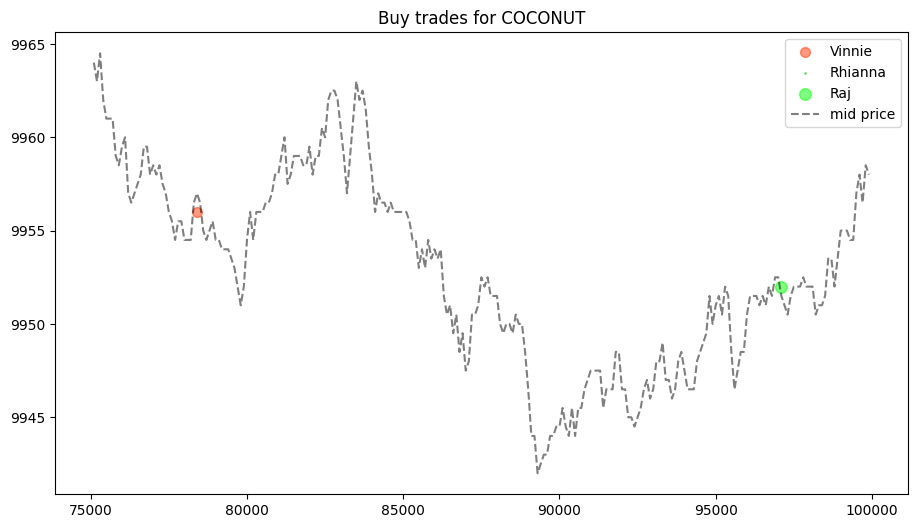

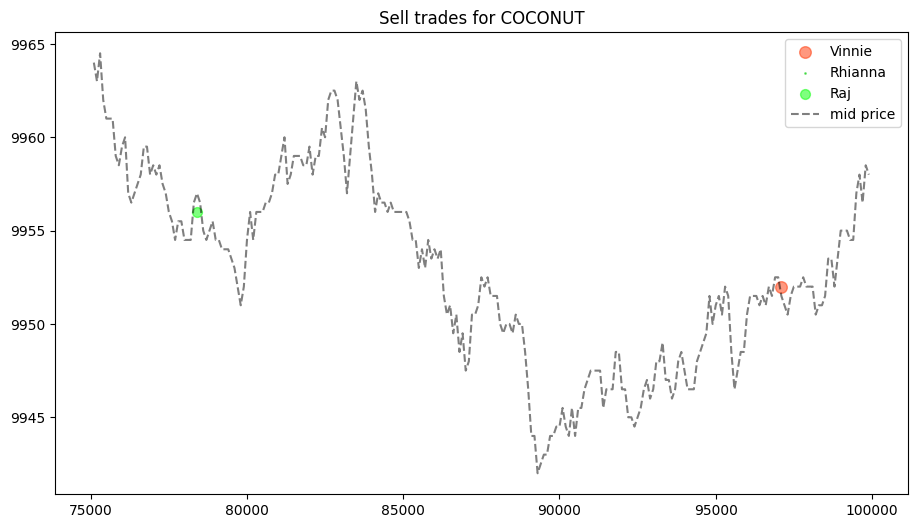

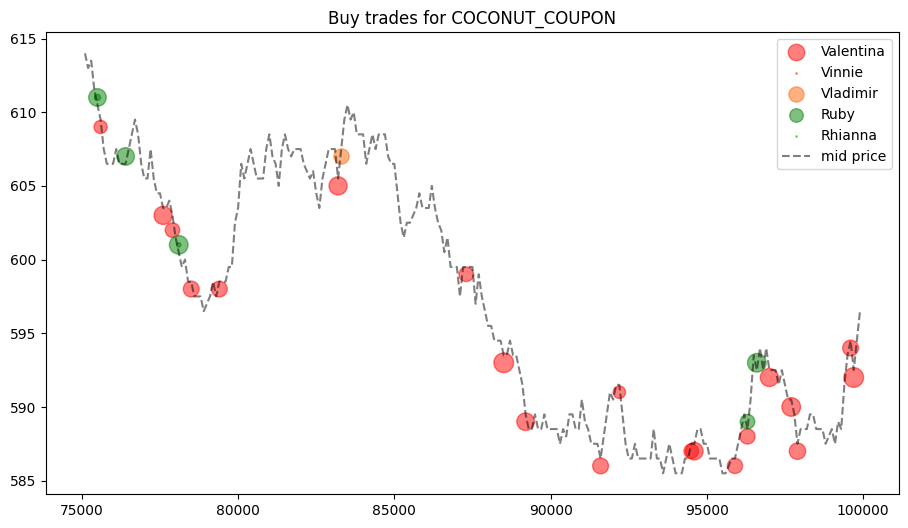

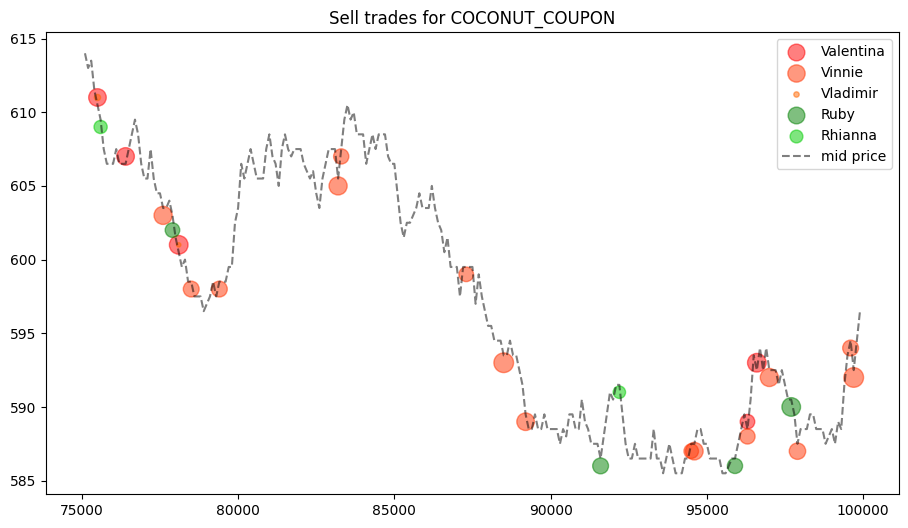

In [132]:
for prod in np.unique(df_trades['symbol']):
    time_range = (75000, 100000)
    
    plot_trades(buy_trades, prod, time_range, title=f"Buy trades for {prod}")
    plot_trades(sell_trades, prod, time_range, title=f"Sell trades for {prod}")

In [115]:
from tqdm import tqdm

def get_weighted_price(trades, prod, bots, t):
    weighted_price = 0
    quantity = 0
    
    for v in bots:
        mask = ((trades['symbol'] == prod) 
            & ((trades['buyer'] == v)) 
            & (trades['timestamp'] == t)
        )
        
        if trades[mask].empty:
            continue
        
        # if size is greater than 1, we have multiple trades
        if len(trades[mask]) > 1:
            continue
        
        trade = trades[mask].iloc[0]
        
        weighted_price += trade['price'] * trade['quantity']
        quantity += trade['quantity']
        
    
    if quantity != 0:
        weighted_price /= quantity
    
    return weighted_price

prod = "COCONUT_COUPON"
# Intentionally ignore Vladimir
vipers = ["Valentina", "Vinnie", "Vivian"]
rattlesnakes = ["Raj", "Rhianna", "Remy", "Ruby"]
 
timestamps = np.unique(df_trades['timestamp']) 

# Dict: timestamp -> price
viper_prices = {}
rattlesnake_prices = {}
mid_prices = {}

for t in tqdm(timestamps):
    viper_price = get_weighted_price(df_trades, prod, vipers, t)
    rattlesnake_price = get_weighted_price(df_trades, prod, rattlesnakes, t)
    
    mid_prices[t] = df_orders[(df_orders['product'] == prod) & (df_orders['timestamp'] == t)].iloc[0]['mid_price']
    if viper_price != 0:
        viper_prices[t] = viper_price
    
    if rattlesnake_price != 0:
        rattlesnake_prices[t] = rattlesnake_price

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1081/1081 [00:05<00:00, 215.24it/s]


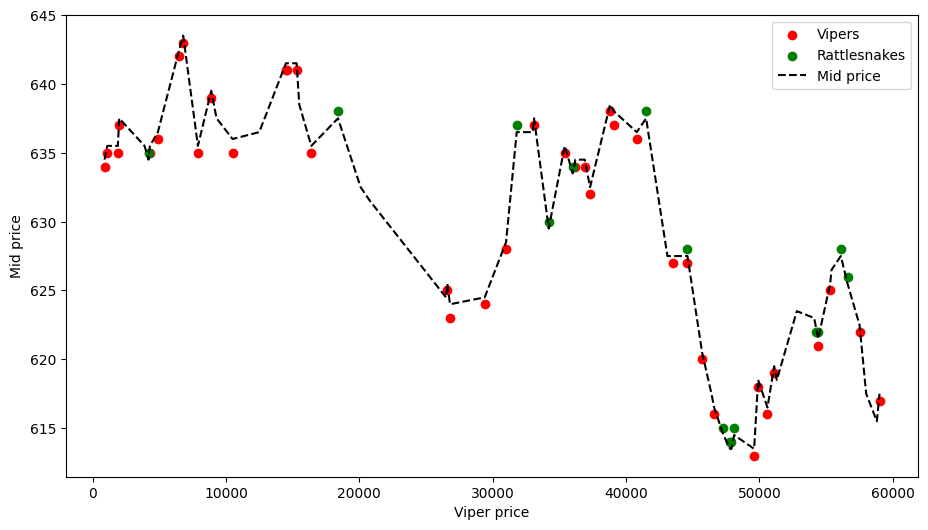

In [116]:
start_key = 0
end_key = 60000

viper_prices_range = {k: viper_prices[k] for k in range(start_key, end_key) if k in viper_prices}
rattlesnake_prices_range = {k:rattlesnake_prices[k] for k in range(start_key, end_key) if k in rattlesnake_prices}
mid_prices_range = {k: mid_prices[k] for k in range(start_key, end_key) if k in mid_prices}

# Scatter viper prices vs mid prices
plt.figure(figsize=(11, 6))
plt.scatter(viper_prices_range.keys(), viper_prices_range.values(), label="Vipers", color="red")
plt.scatter(rattlesnake_prices_range.keys(), rattlesnake_prices_range.values(), label="Rattlesnakes", color="green")
plt.plot(mid_prices_range.keys(), mid_prices_range.values(), label="Mid price", color="black", linestyle='--')
plt.xlabel("Viper price")
plt.ylabel("Mid price")
plt.legend()
plt.show()

# Linear regression

In [117]:
X = []
y = []
y_timestamps = []

for t in timestamps:
    x_vector = [0, 0, mid_prices[t]]
    if t in viper_prices and t in mid_prices:
        x_vector[0] = viper_prices[t]
        
    if t in rattlesnake_prices and t in mid_prices:
        x_vector[1] = rattlesnake_prices[t]
        
    if t+100 in mid_prices:
        X.append(x_vector)
        y_timestamps.append(t + 100)
        y.append(mid_prices[t + 100])
        
X = np.array(X)
y = np.array(y)
        
reg = LinearRegression().fit(X, y)
print(reg.coef_)   
print(reg.intercept_)

[-1.81055137e-05  1.38096350e-04  9.97478496e-01]
1.7631732487199088


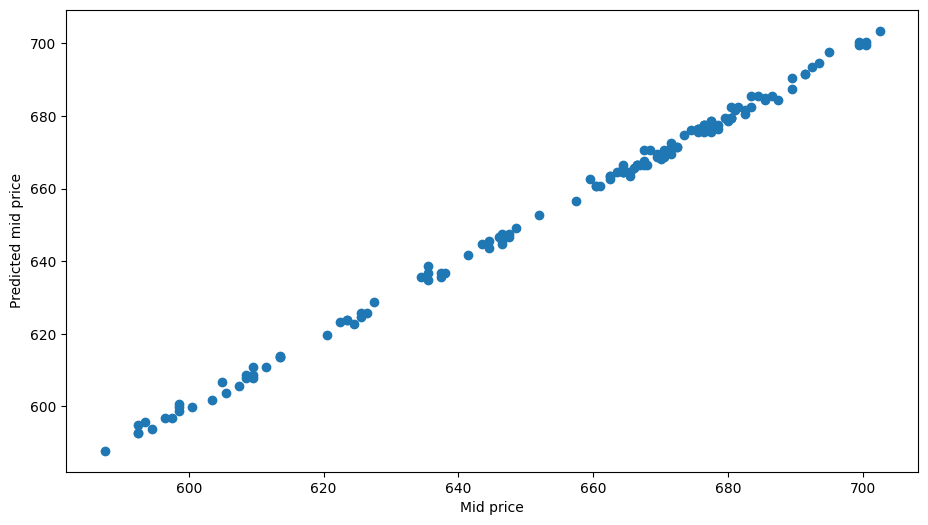

In [118]:
# plot mid price vs predicted mid price
mid_price_pred = reg.predict(X)
plt.figure(figsize=(11, 6))
plt.scatter(y, mid_price_pred)
plt.xlabel("Mid price")
plt.ylabel("Predicted mid price")
plt.show()

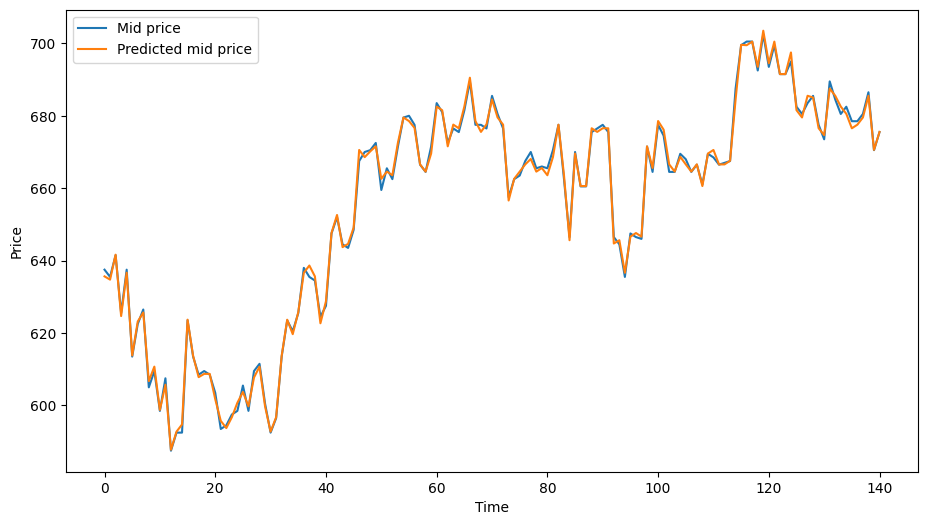

In [119]:
# plot mid price vs predicted mid price
mid_price_pred = reg.predict(X)
plt.figure(figsize=(11, 6))
plt.plot(y, label="Mid price")
plt.plot(mid_price_pred, label="Predicted mid price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

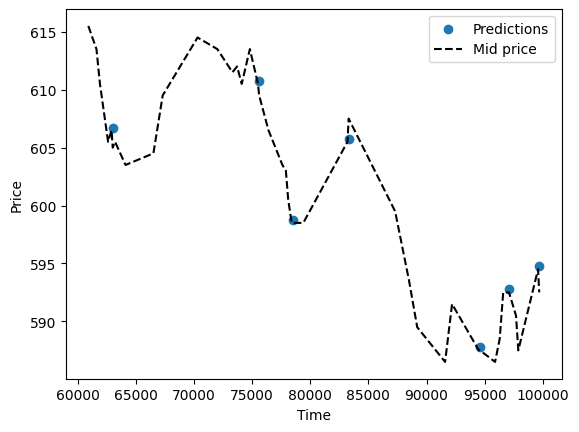

In [120]:
start_range = 60000
end_range = 100000

mid_prices_range = {k: mid_prices[k] for k in range(start_range, end_range) if k in mid_prices}
pred_prices_range = {k: mid_price_pred[i] for i, k in enumerate(y_timestamps) if k >= start_range and k < end_range}

plt.scatter(pred_prices_range.keys(), pred_prices_range.values(), label="Predictions")
plt.plot(mid_prices_range.keys(), mid_prices_range.values(), label="Mid price", color="black", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [121]:
# Print MSE
mse = mean_squared_error(y, mid_price_pred)
print(f"MSE: {mse}")

MSE: 1.4660691096674792


In [122]:
# See gap between predictions and timestamps

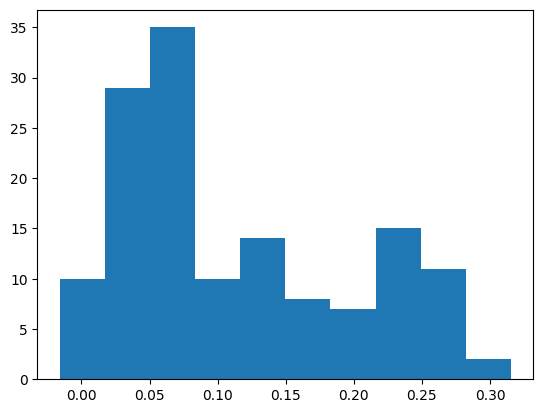

In [123]:
# get only 3rd column of X
mid_prices_pred = reg.predict(X)

diff = mid_prices_pred - X[:, 2]

plt.hist(diff)
plt.show()